In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import ensemble
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set up Test/Train for Clustering

In [42]:
## IMPORT latest dataset:

data = pd.read_csv('all_features.csv',index_col = None)
data = data.drop('Unnamed: 0',axis = 1)
data.shape

(1524, 170)

In [43]:
data_clean = data.dropna(axis=0, how='any')
X = data_clean
X = X.drop(['filenum','filename','classified_shape'] , axis = 1)
X_norm = normalize(X)
Y = data_clean['classified_shape']
X.shape

(1504, 167)

# Supervised Learning

In [44]:
# Standardize features by removing the mean and scaling to unit variance

scaler = StandardScaler()  
scaler.fit(X)  

X = scaler.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=0.25,
    random_state=1200)

### Use PCA for dimension reduction

In [45]:
n_components = 18
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [46]:
X_train_pca = X_train
X_test_pca = X_test

## Neural Network (MLP)

In [47]:
# used randomsearch to find these are the right parameters

mlp_best = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 100, 30, 100), learning_rate='constant',
       learning_rate_init=0.01, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=525,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

mlp_best.fit(X_train_pca, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(60, 100, 30, 100), learning_rate='constant',
              learning_rate_init=0.01, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=525, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [48]:
print(mlp_best.score(X_train_pca,Y_train))
mlp_score = mlp_best.score(X_test_pca,Y_test)
print(mlp_score)

y_pred = mlp_best.predict(X_test_pca)
 
mlp_crosstab = pd.crosstab(Y_test, y_pred, margins=True)
mlp_crosstab

1.0
0.6835106382978723


col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,49,2,16,5,3,75
long,5,46,12,1,4,68
oval,10,7,71,7,4,99
round,2,2,7,46,5,62
square,5,4,12,6,45,72
All,71,61,118,65,61,376


In [49]:
results_df = pd.DataFrame()

In [50]:
# Get the RECALL for each shape and overall
correct_list =[]
shape_list = []
for i in mlp_crosstab.index[0:5]:
    correct = (mlp_crosstab.at[i,i]/mlp_crosstab.at[i,'All'])
    correct = round(correct,2)* 100
    shape_list.append(i)
    correct_list.append(correct)

shape_list.append('Overall')
correct_list.append(round(mlp_score,2)*100)

results_df['shape']= shape_list
results_df['MLP']=correct_list


## KNN Classifier

In [51]:
# use the loop  below to fine tune the K hyperparameter
nn = []
score = []
cv_scores = []
neighbors = range(2,30)
for n in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=n) 
    neigh.fit(X_train_pca, Y_train) 
    sc = neigh.score(X_test_pca,Y_test)
    scores = cross_val_score(neigh, X_train, Y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    nn.append(n)
    score.append(sc)

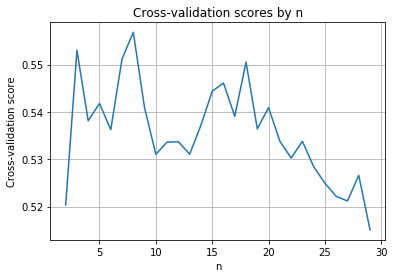

In [52]:
plt.plot(nn,cv_scores)
plt.title('Cross-validation scores by n')
plt.ylabel('Cross-validation score')
plt.xlabel('n')
plt.grid()
plt.show()

The optimal number of neighbors is 8


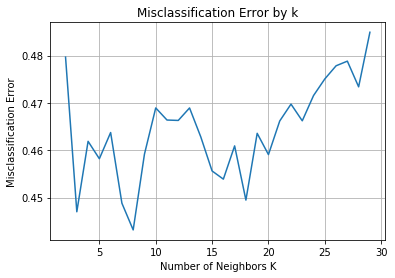

In [53]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.title('Misclassification Error by k')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.grid()
plt.show()

In [14]:
neigh = KNeighborsClassifier(n_neighbors=optimal_k) 
neigh.fit(X_train_pca, Y_train) 
print(neigh.score(X_train_pca,Y_train))
print(neigh.score(X_test_pca,Y_test))
y_pred = neigh.predict(X_test_pca)

KNN_crosstab = pd.crosstab(Y_test, y_pred,margins = True) 
KNN_crosstab

0.6976950354609929
0.5824468085106383


col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,42,8,15,8,2,75
long,7,43,11,1,6,68
oval,15,13,50,10,11,99
round,1,3,6,49,3,62
square,8,11,11,7,35,72
All,73,78,93,75,57,376


In [15]:
correct_list =[]
for i in KNN_crosstab.index[0:5]:
    correct = (KNN_crosstab.at[i,i]/KNN_crosstab.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

correct_list.append(round(neigh.score(X_test_pca,Y_test),2)*100)
results_df['KNN']=correct_list

### Random Forest Classifier

In [16]:
clf = RandomForestClassifier(max_depth=None, random_state=5,n_estimators=90,max_features='sqrt',
                            min_samples_leaf=5,min_samples_split=15,criterion='entropy', bootstrap=True)
clf.fit(X_train_pca, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [17]:
param_grid = { 
    'n_estimators': [50,150, 250, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1,5,10,20,25],
        'min_samples_split': [2,5,10],
    'max_depth': [None,5,10,15,20,25],
    "criterion"         : ["gini", "entropy"],
     "bootstrap": [True]
}

rf_random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv= 5, n_iter = 50)
rf_random_search.fit(X_train_pca, Y_train)
print(rf_random_search.best_estimator_)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


In [18]:
rf_best = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)
rf_best.fit(X_train_pca, Y_train)
print(rf_best.score(X_train_pca,Y_train))
print(rf_best.score(X_test_pca,Y_test))

y_pred = rf_best.predict(X_test_pca)

rfc_crosstab = pd.crosstab(Y_test, y_pred,margins = True) 
rfc_crosstab

1.0
0.6143617021276596


col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,45,5,18,4,3,75
long,3,37,18,1,9,68
oval,9,8,58,10,14,99
round,3,0,5,47,7,62
square,5,4,6,13,44,72
All,65,54,105,75,77,376


In [19]:
correct_list =[]
for i in rfc_crosstab.index[0:5]:
    correct = (rfc_crosstab.at[i,i]/rfc_crosstab.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

In [20]:
correct_list.append(round(rf_best.score(X_test_pca,Y_test),2)*100)
results_df['Random_Forest']=correct_list

### Gradient Boosting

In [21]:
gb_best = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gb_best.fit(X_train_pca, Y_train)
print(gb_best.score(X_train_pca,Y_train))
print(gb_best.score(X_test_pca,Y_test))


1.0
0.6436170212765957


In [22]:
predict_train = gb_best.predict(X_train_pca)
predict_test = gb_best.predict(X_test_pca)

# Accuracy tables.
table_train = pd.crosstab(Y_train, predict_train, margins=True)
table_test = pd.crosstab(Y_test, predict_test, margins=True)

table_test

col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,46,4,12,5,8,75
long,3,37,18,1,9,68
oval,11,5,64,5,14,99
round,2,2,6,47,5,62
square,4,4,8,8,48,72
All,66,52,108,66,84,376


In [23]:
correct_list =[]
for i in table_test.index[0:5]:
    correct = (table_test.at[i,i]/table_test.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

correct_list.append(round(gb_best.score(X_test_pca,Y_test),2)*100)

results_df['Gradient_Boosting']=correct_list

## Linear Discriminant Analysis

In [24]:
# This runs quickly so can run each time if you want.

lda = LinearDiscriminantAnalysis()

param_grid = { 
    'n_components': [1,5,7,10],
    'solver': ['svd'],
    'tol':[0.001,0.01,0.1,0.5]
}
lda.fit(X_train_pca, Y_train)

lda_param_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv= 5)
lda_param_search.fit(X_train_pca, Y_train)
print(lda_param_search.best_estimator_)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.1)


In [25]:
print(lda_param_search.score(X_train_pca, Y_train))
print(lda_param_search.score(X_test_pca, Y_test))

0.7127659574468085
0.6356382978723404


In [26]:
param_grid2 = { 
    'n_components': [1,2,3,10,20],
    'solver': ['eigen','lsqr'],
    'shrinkage': ['auto',0.2,0.5,0.7,1]
}


lda_param_search2 = GridSearchCV(estimator=lda, param_grid=param_grid2, cv= 5)
lda_param_search2.fit(X_train_pca, Y_train)
print(lda_param_search2.best_estimator_)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage='auto',
                           solver='eigen', store_covariance=False, tol=0.0001)


In [27]:
print(lda_param_search2.score(X_train_pca, Y_train))
print(lda_param_search2.score(X_test_pca, Y_test))

0.7074468085106383
0.6303191489361702


In [28]:
predict_test = lda_param_search.predict(X_test_pca)
table_test = pd.crosstab(Y_test, predict_test, margins=True)
table_test

col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,44,4,16,5,6,75
long,6,34,18,1,9,68
oval,10,5,70,7,7,99
round,2,2,9,43,6,62
square,3,10,6,5,48,72
All,65,55,119,61,76,376


In [29]:
correct_list =[]
for i in table_test.index[0:5]:
    correct = (table_test.at[i,i]/table_test.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

correct_list.append(round(lda_param_search.score(X_test_pca,Y_test),2)*100)
results_df['LDA']=correct_list
results_df

,shape,MLP,KNN,Random_Forest,Gradient_Boosting,LDA
0,heart,65.0,56.0,60.0,61.0,59.0
1,long,68.0,63.0,54.0,54.0,50.0
2,oval,72.0,51.0,59.0,65.0,71.0
3,round,74.0,79.0,76.0,76.0,69.0
4,square,62.0,49.0,61.0,67.0,67.0
5,Overall,68.0,58.0,61.0,64.0,64.0


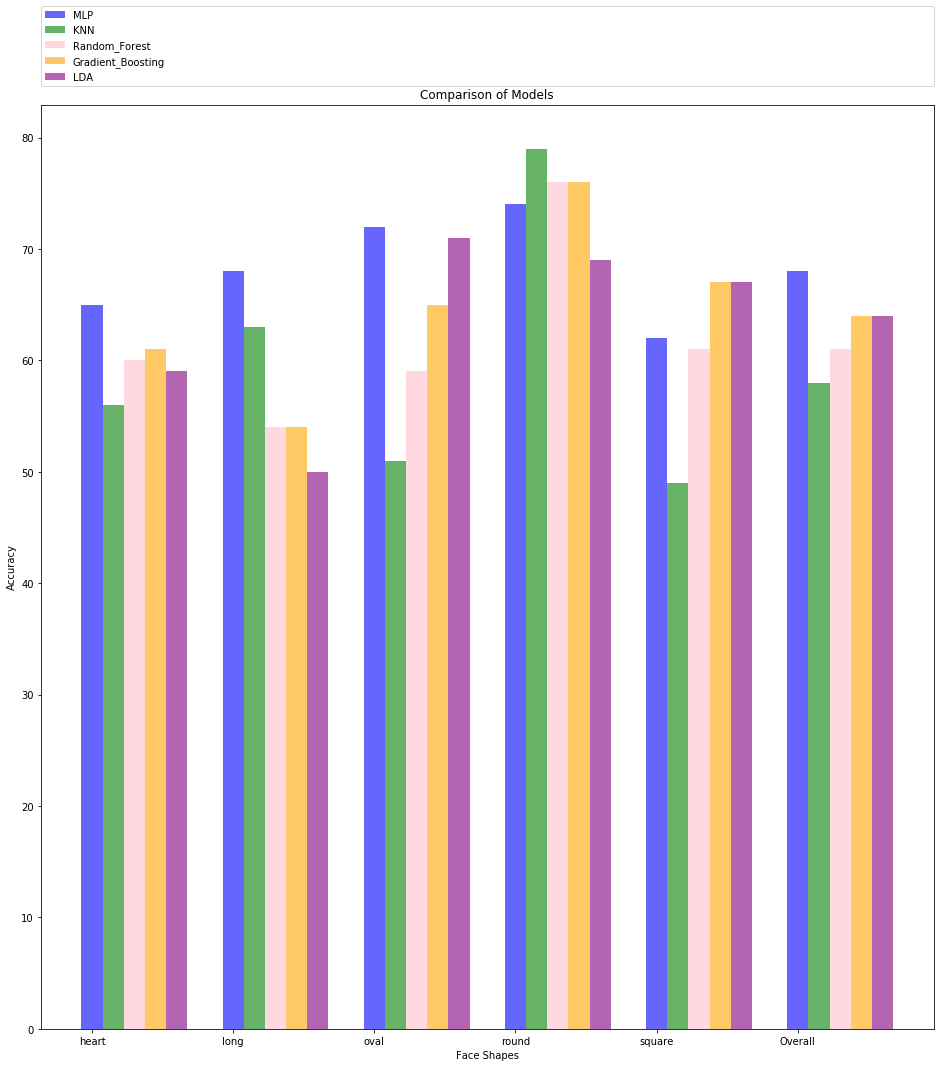

In [40]:
import matplotlib.pyplot as plt

def model_graph():
    ind = np.arange(6)  # the x locations for the groups
    width = 0.15       # the width of the bars

    fig, ax = plt.subplots(figsize=(16, 17))
    al = 0.6
    rects1 = ax.bar(ind, results_df['MLP'], width, color='blue',alpha= al,tick_label = results_df['shape'])
    rects2 = ax.bar(ind + width, results_df['KNN'], width, color='green',alpha= al)
    rects3 = ax.bar(ind + width*2, results_df['Random_Forest'], width, color='pink',alpha= al)
    rects4 = ax.bar(ind + width*3, results_df['Gradient_Boosting'], width, color='orange',alpha= al)
    rects5 = ax.bar(ind + width*4, results_df['LDA'], width, color='purple',alpha= al)

    plt.legend(results_df.iloc[0:0,1:7],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)


    plt.ylabel('Accuracy')
    plt.xlabel('Face Shapes')
    plt.title('Comparison of Models')
    plt.show()
    
model_graph()

The neural network outperformed the other models for overall performance and for four out of the five shapes.

In [32]:
results_df

,shape,MLP,KNN,Random_Forest,Gradient_Boosting,LDA
0,heart,65.0,56.0,60.0,59.0,59.0
1,long,68.0,63.0,54.0,57.0,50.0
2,oval,72.0,51.0,59.0,66.0,71.0
3,round,74.0,79.0,76.0,76.0,69.0
4,square,62.0,49.0,61.0,68.0,67.0
5,Overall,68.0,58.0,61.0,65.0,64.0
